In [1]:
import numpy as np
from stochasticdensity import gaussian_process_model as gpm
from stochasticdensity.gaussian_process_model import GPModel
from bayesiankalman import kalmanfilter as kf
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [2]:
%matplotlib inline  

## Simulation ##

In [3]:
num_obs_per_day = 100
num_periods = 500
nsims = 200

In [4]:
gp_model_sim = gpm.simulate_gp_model(vol_coeff=[0, .8, .1, .05], lag_indices=np.array([1, 7, 29]), 
                                     num_obs_per_day=num_obs_per_day, drift=.1,
                                     means_ar_coeff=.9,data_innov_var=.1, num_periods=num_periods)

> /home/sangrey/Repositories/RealizedDensityEstimation/realizeddensity/gaussian_process_model.py(287)__init__()
    285                  innov_var=None, ranges=None):
    286         Tracer()()
--> 287         if ivols is not None:
    288             if np.isscalar(ivols) and num_periods is not None:
    289                 self.ivols = np.full(num_periods, fill_value=ivols, dtype=np.double)

ipdb> c


## Estimation Setup ##

In [5]:
data = gp_model_sim.data.copy()
vol_coeff = gp_model_sim.vol_coeff.copy()
lag_indices = gp_model_sim.lag_indices.copy()
vol_innov_var = np.asarray(gp_model_sim.vol_innov_var)
means = gp_model_sim.means.copy()
ivols = gp_model_sim.ivols.copy()
mean_coeff = gp_model_sim.mean_coeff.copy()
drift_innov_var = np.asarray(gp_model_sim.drift_innov_var).copy()

In [6]:
prior = {'ivol': {'vol_coeff': {'mean': np.zeros(vol_coeff.size), 'cov': 10 * np.eye(vol_coeff.size)},
                  'innov_var': {'shape': 3, 'scale': .1}},
         'means': {'innov_var': {'shape': 3, 'scale': .1}, 
                    'mean_coeff': {'mean': np.array([0,0]), 'var': 10 * np.eye(2)} }
        }

In [7]:
vol_coeff_sims = np.empty((nsims,) + vol_coeff.shape)
vol_innov_var_sims = np.empty((nsims,) + vol_innov_var.shape)
means_sims = np.empty((nsims,) + means.shape)
ivols_sims = np.empty((nsims,) + ivols.shape)
mean_coeff_sims = np.empty((nsims,) + mean_coeff.shape)
drift_innov_var_sims = np.empty((nsims,) + drift_innov_var.shape)

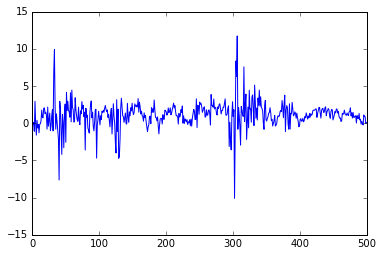

In [8]:
plt.plot(np.sum(gp_model_sim.data, axis=1))

## Estimation ##

In [9]:
for idx in tqdm(range(nsims)):
    draw = gp_model_sim(prior)
    vol_coeff_sims[idx] = draw['vol_coeff'].reshape(vol_coeff.shape)
    vol_innov_var_sims[idx] = draw['vol_innov_var'].reshape(vol_innov_var.shape)
    means_sims[idx] = draw['means'].reshape(means.shape)
    ivols_sims[idx] = draw['ivols'].reshape(ivols.shape)
    mean_coeff_sims[idx] = draw['mean_coeff'].reshape(mean_coeff.shape)
    drift_innov_var_sims[idx] = draw['drift_innov_var'].reshape(drift_innov_var.shape)
    

## Evaluation ##

In [10]:
mean_df = pd.DataFrame(np.hstack([means.reshape(means.size,1), 
                        np.squeeze(np.percentile(means_sims, (5, 50, 95), axis=0)).T]))
mean_df.columns = ['means', '5th pct', '50th pct', '95th pct']
print(mean_df)

        means   5th pct  50th pct  95th pct
0    0.544985 -0.408426  0.108066  0.678236
1    0.116158 -0.476585  0.085019  0.644275
2    0.295500 -0.488626  0.160416  0.746295
3    0.343542 -0.566016  0.093874  0.721295
4   -0.186966 -0.348988  0.361688  1.091824
5   -0.124613 -0.594603  0.058218  0.750135
6   -0.619241 -0.883502 -0.287268  0.297907
7   -0.847436 -0.696772 -0.147708  0.477194
8   -0.798981 -0.928910 -0.226419  0.355553
9   -0.802373 -1.017993 -0.333140  0.232683
10  -0.669502 -1.087740 -0.638312 -0.103498
11  -0.211035 -0.725822 -0.235072  0.406200
12   0.273116 -0.441220  0.136101  0.666629
13   0.557831  0.097065  0.543241  1.151449
14   0.676043  0.530995  1.105138  1.700283
15   0.961571  0.529567  1.088208  1.732493
16   0.938242  0.723383  1.177849  1.643961
17   1.808103  1.020028  1.546142  2.028640
18   1.348848  0.958166  1.554265  2.157506
19   0.872519  0.752691  1.414986  2.053182
20   0.884665  0.661187  1.295072  1.792555
21   0.742536  0.520906  1.00321

In [11]:
{key: np.mean(np.greater_equal(mean_df['means'], mean_df[key])) for key in mean_df.keys()[1:] }

{'50th pct': 0.53000000000000003,
 '5th pct': 0.96799999999999997,
 '95th pct': 0.085999999999999993}

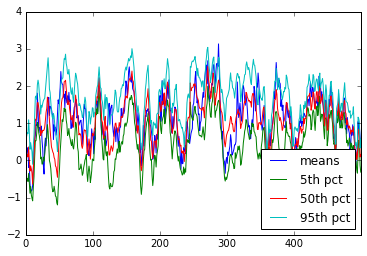

In [12]:
mean_df.plot()

In [13]:
print(drift_innov_var)
pd.DataFrame(np.percentile(drift_innov_var_sims, (5, 50, 95), axis=0))

0.1


0
0  0.115757
1  0.148076
2  0.203547

In [14]:
print(mean_coeff)
pd.DataFrame(np.percentile(mean_coeff_sims, (5, 50, 95), axis=0))

[ 0.1  0.9]


0         1
0  0.143491  0.803027
1  0.179291  0.837168
2  0.216456  0.866748

In [15]:
ivol_df = pd.DataFrame(np.hstack([ivols.reshape(means.size,1), 
                        np.squeeze(np.percentile(ivols_sims, (5, 50, 95), axis=0)).T]))
ivol_df.columns = ['ivols', '5th pct', '50th pct', '95th pct']
print(ivol_df)

        ivols   5th pct  50th pct  95th pct
0    0.503020  0.335956  0.427454  0.549247
1    1.064037  0.970436  1.237754  1.542238
2    0.667927  0.508918  0.646942  0.799883
3    0.817074  0.628588  0.783741  1.077541
4    1.872896  1.423872  1.824546  2.232406
5    0.464431  0.373803  0.461719  0.579861
6    0.279767  0.277661  0.346165  0.454813
7    1.146495  0.865538  1.032034  1.258096
8    0.859332  0.636065  0.801750  1.027687
9    0.152515  0.147258  0.187245  0.226907
10   0.860902  0.637815  0.804962  1.029031
11   0.174080  0.169959  0.225078  0.255963
12   0.863579  0.557023  0.728688  0.952332
13   0.236218  0.175916  0.210393  0.262189
14   0.286297  0.305954  0.398485  0.556044
15   0.213489  0.242448  0.316284  0.383493
16   0.185685  0.161536  0.197260  0.254688
17   0.463708  0.407852  0.511057  0.624970
18   0.464192  0.369134  0.458883  0.585222
19   0.305075  0.286005  0.366012  0.457123
20   0.142042  0.159484  0.204104  0.250262
21   0.431306  0.442026  0.54386

In [16]:
{key: np.mean(np.greater_equal(ivol_df['ivols'], ivol_df[key])) for key in ivol_df.keys()[1:] }

{'50th pct': 0.31,
 '5th pct': 0.64000000000000001,
 '95th pct': 0.048000000000000001}

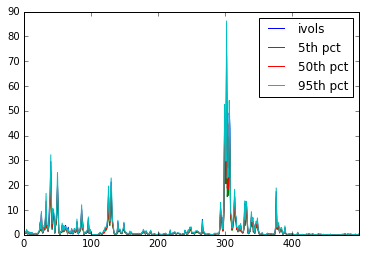

In [17]:
ivol_df.plot()

In [18]:
print(vol_coeff)
pd.DataFrame(np.percentile(vol_coeff_sims, (5, 50, 95), axis=0))

[ 0.    0.8   0.1   0.05]


0         1         2         3
0 -0.039259  0.751229  0.148402  0.049397
1 -0.034690  0.759239  0.154824  0.054783
2 -0.031574  0.766918  0.161174  0.060121

In [19]:
print(vol_innov_var)
pd.DataFrame(np.percentile(vol_innov_var_sims, (5, 50, 95), axis=0))

1


0
0  0.573949
1  0.642498
2  0.720002